In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import projx as px
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
def prob_dist(itrbl):
    count = {}
    for i in itrbl:
        count.setdefault(i, 0)
        count[i] += 1
    sr = pd.Series(count)
    prob = sr.apply(lambda x: float(x) / len(itrbl))
    return prob

def basic_graph_stats(g):
    stats = {
        "num_nodes": len(g),
        "num_edges": len(g.edges()),
        "density": nx.density(g),
        "diameter": nx.diameter(g),
        "avg_short_path": nx.average_shortest_path_length(g),
        "avg_clust": nx.average_clustering(g)
    }
    return pd.Series(stats)    

In [5]:
graph = nx.read_gexf("projections/onemode.gexf")

In [6]:
subgraphs = list(nx.connected_component_subgraphs(graph))
print([len(sub) for sub in subgraphs])

[305, 5, 8]


In [7]:
g = subgraphs[0]
g1 = subgraphs[1]
g2 = subgraphs[2]

In [8]:
nx.write_gexf(g, "projections/subgraph_onemode.gexf")

In [9]:
print(basic_graph_stats(g))

avg_clust            0.798456
avg_short_path       2.635656
density              0.046894
diameter             6.000000
num_edges         2174.000000
num_nodes          305.000000
dtype: float64


In [10]:
roles = [a.get("role", "") for (n, a) in g.nodes(data=True)]  # Hmm.
places = [a["top_place"] for (n, a) in g.nodes(data=True)]
genres = [a["top_genre"] for (n, a) in g.nodes(data=True)]
sr = pd.Series({"role": prob_dist(roles), "place": prob_dist(places), "genre": prob_dist(genres)})

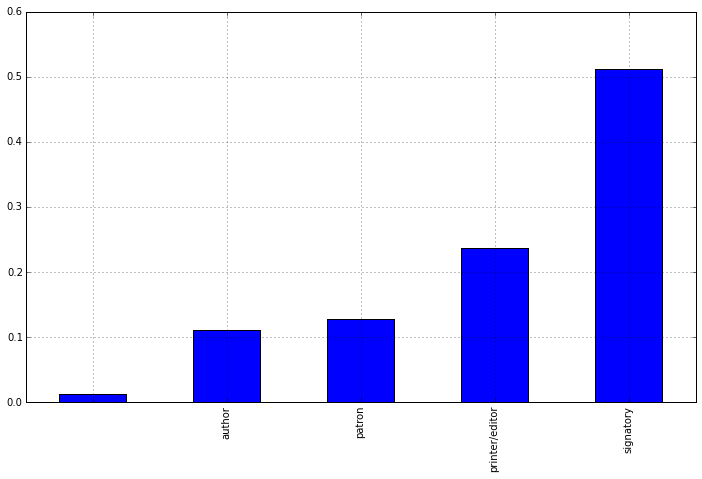

In [11]:
prob_dist(roles).plot(kind="bar")
plt.savefig("img/roles.png")

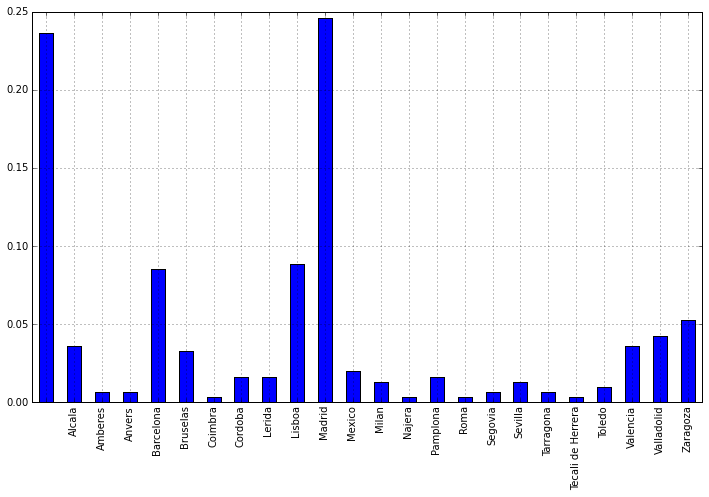

In [12]:
prob_dist(places).plot(kind="bar")
plt.savefig("img/places.png")

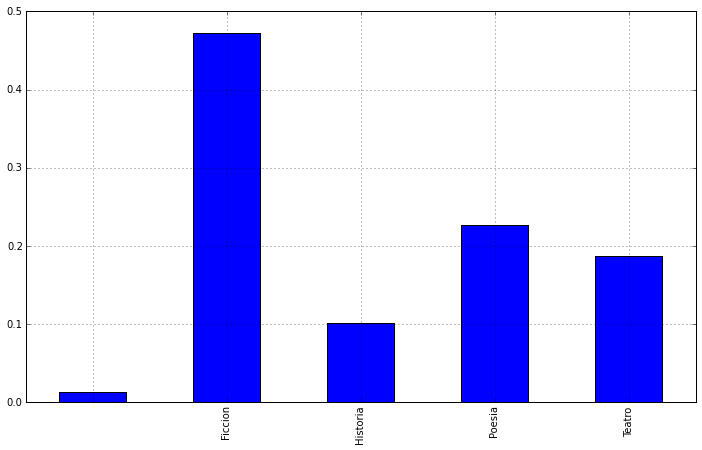

In [13]:
prob_dist(genres).plot(kind="bar")
plt.savefig("img/genres.png")

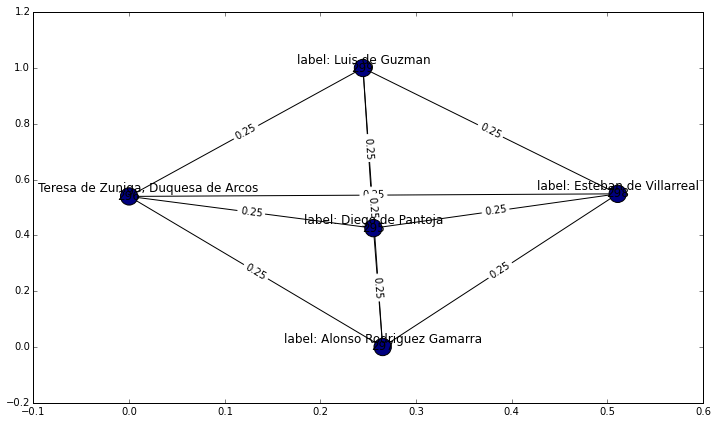

In [14]:
px.draw_simple_graph(g1)
#plt.savefig("img/china_component.png")

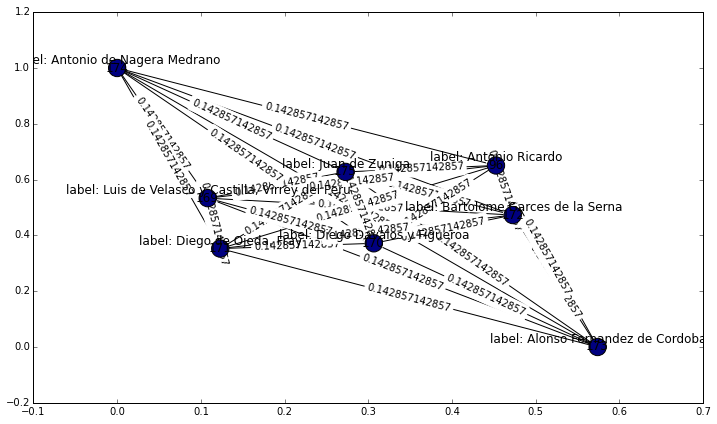

In [15]:
px.draw_simple_graph(g2)
#plt.savefig("img/peru_component.png")

In [16]:
print(len(g), len(g.edges()), nx.density(g))

(305, 2174, 0.04689387402933563)


### Centrality

In [17]:
bc = nx.betweenness_centrality(g, weight="weight")
ec = nx.eigenvector_centrality(g, weight="weight", max_iter=500)
cc = nx.closeness_centrality(g)
deg = nx.degree(g)
pr = nx.pagerank(g, max_iter=500, weight="weight")

In [18]:
cent_10_df = pd.DataFrame({
    "bc": [(k, g.node[k]["label"], bc[k]) for k in sorted(bc, key=bc.get, reverse=True)[0:10]],
    "ec": [(k, g.node[k]["label"], ec[k]) for k in sorted(ec, key=ec.get, reverse=True)[0:10]],
    "cc": [(k, g.node[k]["label"], cc[k]) for k in sorted(cc, key=cc.get, reverse=True)[0:10]],
    "dc": [(k, g.node[k]["label"], deg[k]) for k in sorted(deg, key=deg.get, reverse=True)[0:10]],
    #"pr": [(k, g.node[k]["label"], pr[k]) for k in sorted(pr, key=pr.get, reverse=True)[0:10]]
})

In [19]:
print(cent_10_df)

                                                  bc  \
0   (440, Felix Lope de Vega Carpio, 0.200959596595)   
1  (215, Francisco Murcia de la Llana, 0.18434085...   
2  (389, Viuda de Luis Martinez Grande, 0.1217171...   
3  (184, Pedro Fernandez de Castro, Conde de Lemo...   
4  (100, Gutierre de Cetina, Vicario General, 0.0...   
5              (257, Jorge de Tovar, 0.079025820713)   
6                (70, Mateo Aleman, 0.0761722444174)   
7                      (392, Pinto, 0.0502513457591)   
8                (437, Alonso Perez, 0.047479987384)   
9     (153, Sebastian de Cormellas, 0.0462965375485)   

                                                  cc  \
0  (215, Francisco Murcia de la Llana, 0.57794676...   
1   (440, Felix Lope de Vega Carpio, 0.576850094877)   
2  (100, Gutierre de Cetina, Vicario General, 0.5...   
3  (184, Pedro Fernandez de Castro, Conde de Lemo...   
4  (208, Miguel de Cervantes Saavedra, 0.50331125...   
5                (18, Roger Velpius, 0.50165016

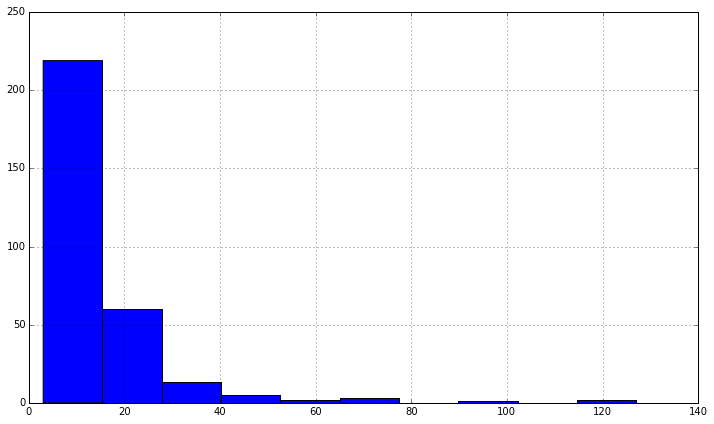

In [20]:
pd.Series(deg.values()).hist()

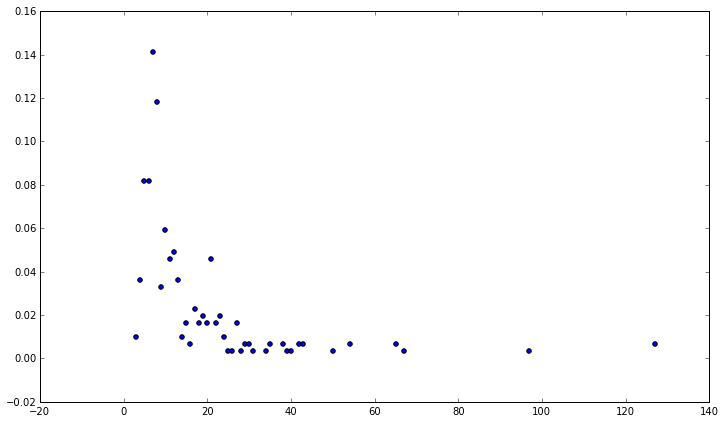

In [21]:
deg_prob = prob_dist(deg.values())
plt.scatter(deg_prob.index, deg_prob)
plt.savefig("img/deg_dist.png")

### Degree by role

In [22]:
authors = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "author"]).values())
patrons = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "patron"]).values())
printers = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "printer/editor"]).values())
signatories = pd.Series(nx.degree(g, nbunch=[n for (n, a) in g.nodes(data=True) if a.get("role") == "signatory"]).values())

In [23]:
# plt.plot(authors.index, authors, color="r")
# plt.plot(patrons.index, patrons, color="b")
# plt.plot(printers.index, printers, color="y")
# plt.plot(signatories.index, signatories, color="g")
df = pd.concat([authors, patrons, printers, signatories], axis=1, keys=["author", "patron", "printer", "signatory"])
df.describe()

,author,patron,printer,signatory
count,34.000000,39.000000,72.000000,156.000000
mean,21.411765,11.794872,11.791667,14.410256
std,23.032411,11.107559,10.029446,14.771757
min,4.000000,4.000000,3.000000,3.000000
25%,8.250000,7.000000,6.000000,7.000000
50%,16.500000,8.000000,7.500000,10.000000
75%,21.000000,10.500000,13.000000,17.000000
max,127.000000,67.000000,50.000000,127.000000


{'boxes': [<matplotlib.lines.Line2D at 0x7f3396a0a3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f33969fff90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f33965c13d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f33969ff910>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3396a0aa90>,
  <matplotlib.lines.Line2D at 0x7f3396921b10>]}

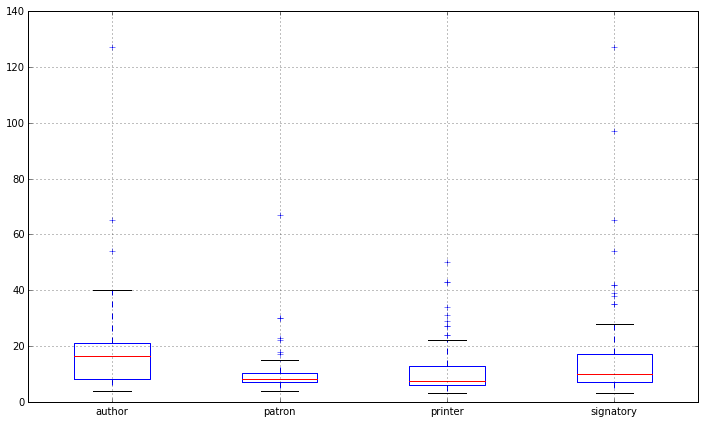

In [24]:
df.boxplot()

In [25]:
g.nodes(data=True)

[('214',
  {'avg_date': u'1616',
   'doc_type': u"{u'Tasa': 8, u'Privilegio/Licencia': 2}",
   'fecha': u"{'1614-11-17': 1, '1615-10-21': 1, '1616-09-12': 1, '1618-06-25': 1, '1618-01-29': 1, '1617-11-07': 1, '1617-08-18': 1, '1613-08-12': 1, '1618-03-06': 1, '1618-04-09': 1}",
   'genero': u"{'Teatro': 1, 'Ficcion': 5, 'Poesia': 3}",
   'inst': u"{u'Consejo de Castilla': 1}",
   'label': 'Hernando de Vallejo',
   'lugar': u"{u'Madrid': 10}",
   'notas': u"{'Escribano de Camara': 1}",
   'real': u"{'True': 1}",
   'role': u'signatory',
   'second_genre': u'Poesia',
   'second_place': u'',
   'top_genre': u'Ficcion',
   'top_place': u'Madrid',
   'type': u'Persona'}),
 ('215',
  {'avg_date': u'1612',
   'doc_type': u"{u'Privilegio/Licencia': 1, u'Fe de erratas': 33}",
   'fecha': u"{'': 8, '1612-02-08': 1, '1614-05-15': 1, '1604-12-20': 1, '1618-03-13': 1, '1611-04-09': 1, '1615-10-21': 1, '1614-09-20': 1, '1616-12-15': 1, '1613-08-07': 1, '1612-11-02': 1, '1618-06-23': 1, '1614-11-10':

In [28]:
cent_df = pd.DataFrame({
    "dc": nx.degree_centrality(g).values(),    
    "bc": bc.values(),
    "cc": cc.values(),
    "ec": ec.values(),
})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3396af0950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f33969c9b50>]], dtype=object)

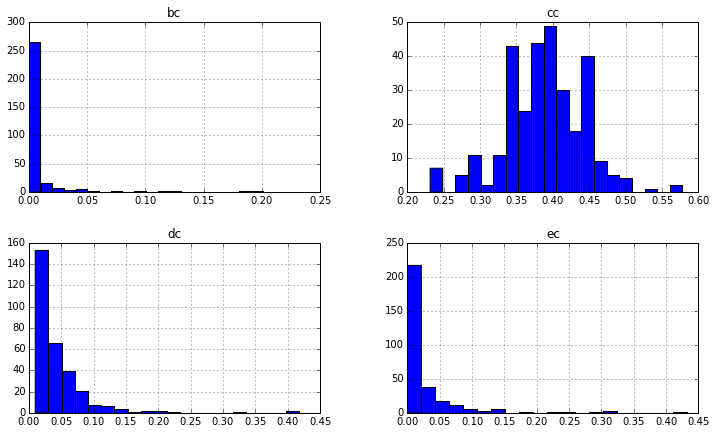

In [29]:
cent_df.hist(bins=20)

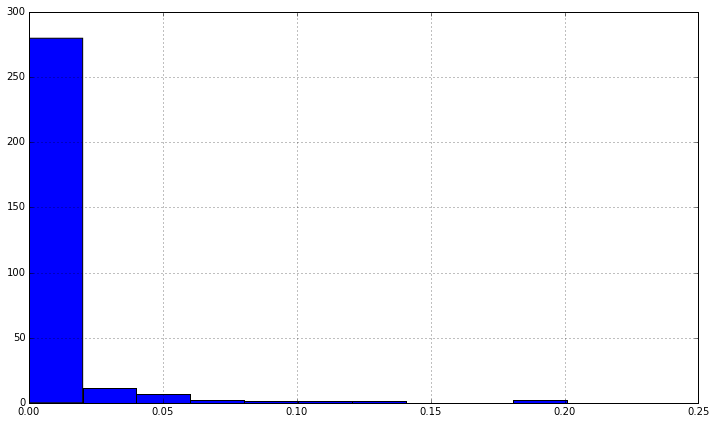

In [30]:
pd.Series(bc.values()).hist()

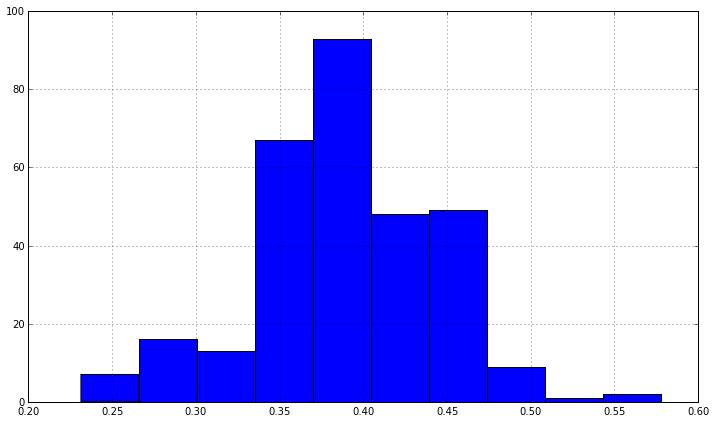

In [25]:
pd.Series(cc.values()).hist()

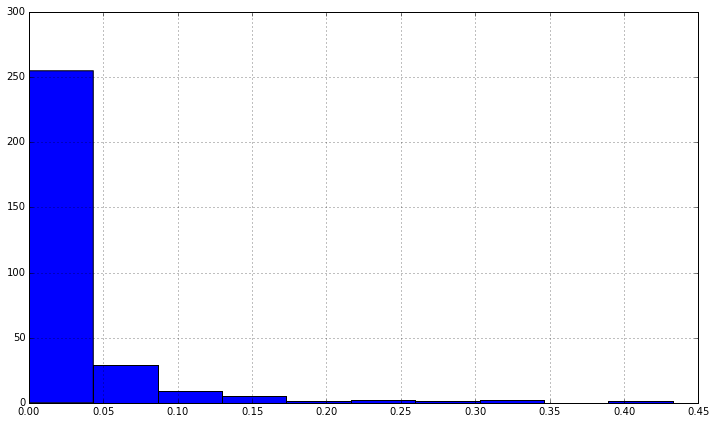

In [26]:
pd.Series(ec.values()).hist()

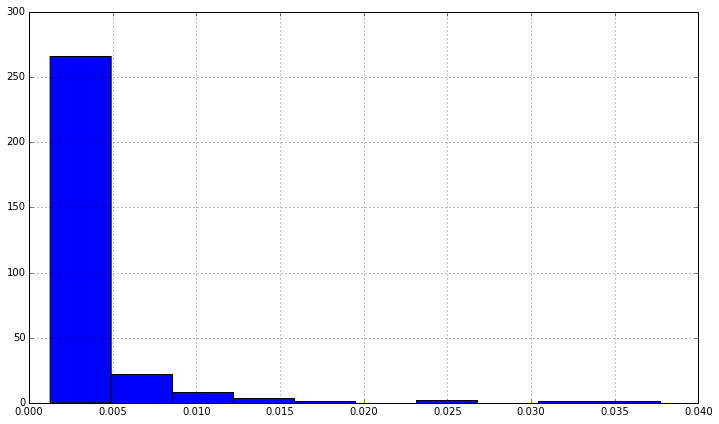

In [27]:
pd.Series(pr.values()).hist()

### Assortativity

#### Degree

In [28]:
nx.degree_assortativity_coefficient(g)

-0.12421390061378558

In [29]:
r = nx.degree_assortativity_coefficient(g)
print("%3.1f"%r)

-0.1


In [30]:
nodes_by_deg = sorted(deg, key=deg.get, reverse=True)
mtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)

In [31]:
weight_sr = pd.Series([attrs["weight"] for s, t, attrs in g.edges(data=True)])
weight_sr.describe()

count    2174.000000
mean        0.203542
std         0.197535
min         0.052632
25%         0.111455
50%         0.142857
75%         0.200000
max         2.602381
dtype: float64

In [32]:
quant = weight_sr.quantile(.75)

In [33]:
plt.rcParams['figure.figsize'] = (17, 12)

<matplotlib.colorbar.Colorbar instance at 0x7f52e9b04950>

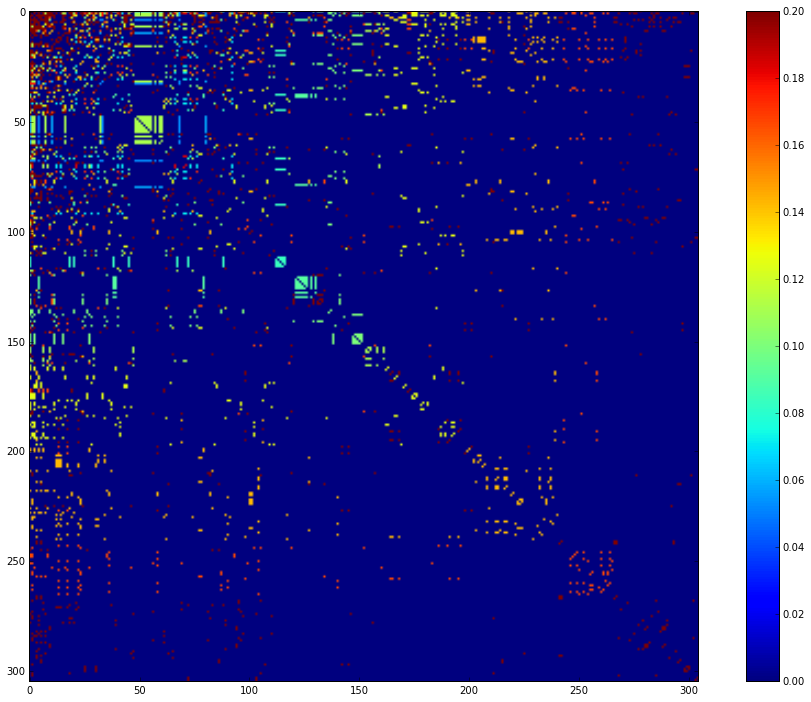

In [34]:
heatmap = plt.imshow(mtrx)
heatmap.set_clim(0.0, quant)
plt.colorbar()

In [35]:
stripmtrx = mtrx[:, :100]

<matplotlib.colorbar.Colorbar instance at 0x7f52e999e680>

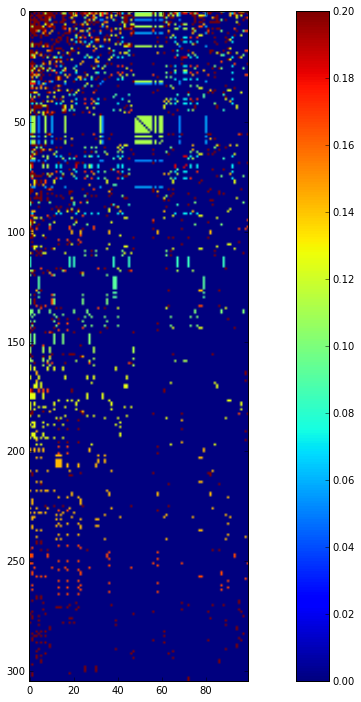

In [36]:
heatmap = plt.imshow(stripmtrx)
heatmap.set_clim(0.0, quant)
plt.colorbar()

In [37]:
zoommtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)[:50, :50]

In [38]:
zoomquant = pd.Series(zoommtrx.flatten().tolist()[0]).quantile(0.9)

<matplotlib.colorbar.Colorbar instance at 0x7f52e9827cb0>

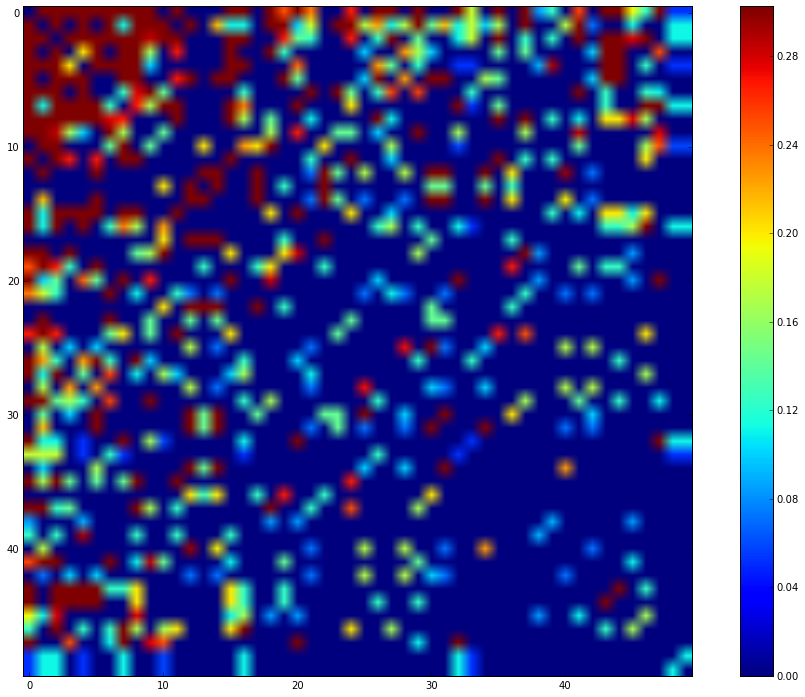

In [39]:
heatmap = plt.imshow(zoommtrx)
heatmap.set_clim(0.0, zoomquant)
plt.colorbar()

#### Attribute

In [40]:
nx.attribute_assortativity_coefficient(g, "top_place")

0.22971913069957403

In [41]:
nx.attribute_assortativity_coefficient(g, "top_genre")

0.4682799851456054

In [42]:
nx.attribute_assortativity_coefficient(g, "role")

-0.05108223122899631

In [56]:
len(g.edges())

2174

In [63]:
def edge_types(g):
    tps = {}
    for s, t, attrs in g.edges(data=True):
        srole = g.node[s].get("role", "")
        trole = g.node[t].get("role", "")
        if srole and trole:
            if (trole, srole) in tps:
                tps[(trole, srole)].append(attrs["weight"])
            else:
                tps.setdefault((srole, trole), [])
                tps[(srole, trole)].append(attrs["weight"])
    return tps

def edge_aggs(tps):
    aggs = {}
    for k, v in tps.items():
        aggs[k] = (len(v) / 2174.0, sum(v) / len(v))
    return aggs

In [64]:
etps = edge_types(g)
aggs = edge_aggs(etps)

In [65]:
aggs

{(u'author', u'author'): (0.029438822447102116, 0.14633976946031252),
 (u'patron', u'author'): (0.025298988040478382, 0.3882178932178363),
 (u'patron', u'patron'): (0.0027598896044158236, 0.16170634920633334),
 (u'printer/editor', u'author'): (0.07681692732290708, 0.2152066673349583),
 (u'printer/editor', u'patron'): (0.05887764489420423, 0.19259672619050142),
 (u'printer/editor', u'printer/editor'): (0.017939282428702852,
  0.19724899856476158),
 (u'signatory', u'author'): (0.16697332106715732, 0.2289808632624276),
 (u'signatory', u'patron'): (0.12005519779208831, 0.21472511098950098),
 (u'signatory', u'printer/editor'): (0.2125114995400184, 0.18813446068583392),
 (u'signatory', u'signatory'): (0.2608095676172953, 0.18626572431797458)}

In [1]:
2174 * 0.025

54.35

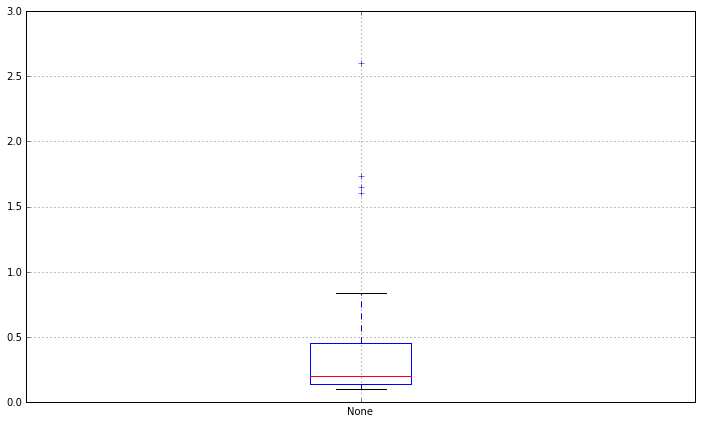

In [52]:
pd.Series(etps[(u'patron', u'author')]).plot(kind="box")

### Clustering

In [43]:
nx.average_clustering(g)

0.7984559094148668

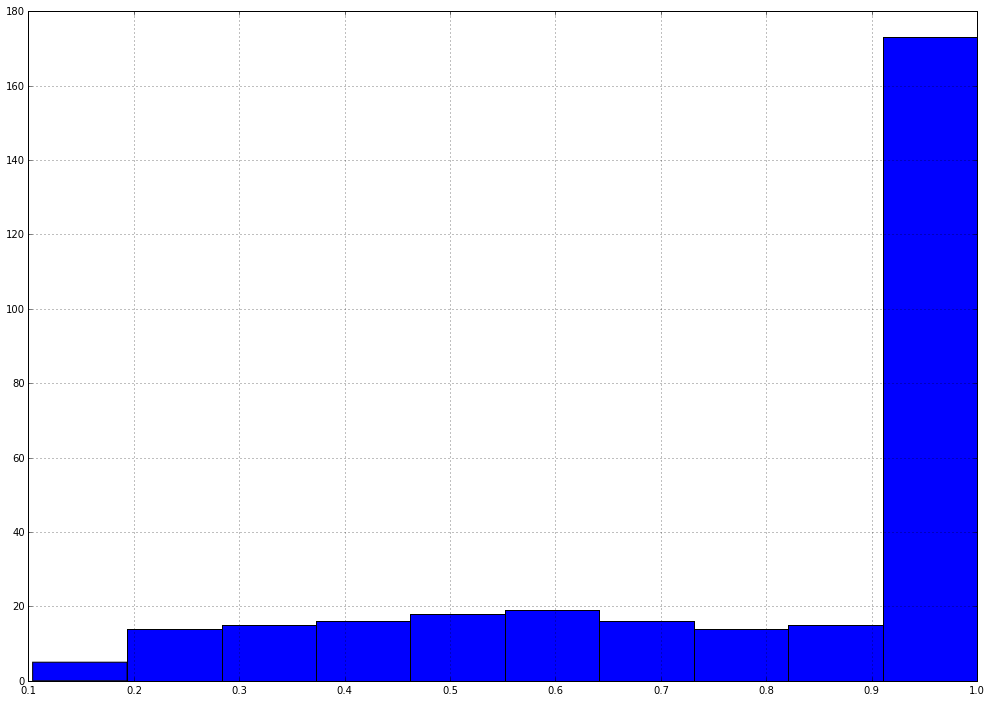

In [44]:
pd.Series(nx.clustering(g).values()).hist()

In [45]:
nx.transitivity(g)

0.3456422537946212

### Paths

In [46]:
nx.diameter(g)

6

In [47]:
nx.average_shortest_path_length(g)

2.635655737704918